# Install and import library

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from datetime import datetime

In [ ]:
from sklearn.preprocessing import MinMaxScaler, normalize
from sklearn.metrics import mean_squared_error
import math
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error

# Evaluation function:

In [ ]:
def evaluation(y_test, y_pred):
  print(f'RMSE = {math.sqrt(mean_squared_error(y_test, y_pred))}')
  print(f'MAPE = {mean_absolute_percentage_error(y_test, y_pred)*100}')
  print(f'MAE = {mean_absolute_error(y_test, y_pred)}')

# Preprocessing Dataset

In [ ]:
df = pd.read_csv('/content/FPT.csv')

In [ ]:
df

,Date,Price
0,12/15/2016,15077.4
1,12/16/2016,15167.5
2,12/19/2016,15383.6
3,12/20/2016,15329.6
4,12/21/2016,15311.6
...,...,...
1745,12/11/2023,95000.0
1746,12/12/2023,96800.0
1747,12/13/2023,95200.0
1748,12/14/2023,96200.0


In [ ]:
list_reference_date = [datetime.strptime(date_str, '%m/%d/%Y') for date_str in df['Date']]

In [ ]:
reference_date = min(list_reference_date)
from datetime import datetime
df['numerical_date'] = df['Date'].apply(lambda x: (datetime.strptime(x, '%m/%d/%Y') - reference_date).days)

In [ ]:
df_ = df['Price'].values.reshape(-1, 1)

In [ ]:
scaler = MinMaxScaler()
df['Price'] = scaler.fit_transform(df_)
df1= df['Price'].copy()

In [ ]:
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step)]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step])
	return np.array(dataX), np.array(dataY)

# Split train, test

In [ ]:
def split_data(train_ratio, test_ratio):
  train_size = int(train_ratio * len(df1))
  test_size = int(test_ratio * len(df1))

  train_data = df1[:train_size]
  test_data = df1[train_size:train_size+test_size].reset_index(drop=True)
  return train_size, test_size, train_data, test_data

# **BNN**

## Split data 7:3


In [ ]:
train_size, test_size, train_data, test_data = split_data(0.7, 0.3)

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.distributions import Normal

# Set random seed for reproducibility
torch.manual_seed(42)

# Define the hyperparameters
input_dim = X_train.shape[1]  # Dimension of input features
output_dim = 1  # Dimension of output (predicted value)
hidden_units = 64  # Number of hidden units
learning_rate = 0.001
num_epochs = 500
prior_sigma = 0.1  # Standard deviation of the prior

# Apply Min-Max scaling to the time series data

# Convert the scaled data to tensors
targets = torch.tensor(y_train).view(-1, 1).to(torch.float32)
time_series = torch.tensor(X_train).to(torch.float32)

# Create a DataLoader for batching and shuffling the data
dataset = TensorDataset(time_series, targets)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Define the BNN model
class BNNModel(nn.Module):
    def __init__(self, input_dim, hidden_units, output_dim, prior_sigma):
        super(BNNModel, self).__init__()
        self.layer1 = nn.Linear(input_dim, hidden_units)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(hidden_units, output_dim)
        self.prior_sigma = prior_sigma

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        return x

    def kl_divergence(self):
        kl = 0
        for layer in [self.layer1, self.layer2]:
            weights = layer.weight
            kl += 0.5 * (torch.log(self.prior_sigma**2 / weights.var()) + (weights.var() + (weights.mean() - 0)**2) / self.prior_sigma**2 - 1)
        return kl

# Initialize the BNN model
model = BNNModel(input_dim, hidden_units, output_dim, prior_sigma)

# Define the loss function with KL divergence and negative log likelihood
def bnn_loss(outputs, targets):
    kl_divergence = model.kl_divergence()
    log_likelihood = -Normal(outputs, 1).log_prob(targets).mean()  # Assuming outputs is a Normal distribution
    return kl_divergence + log_likelihood

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
lowest_loss = float('inf')  # Initialize with positive infinity

# Training loop
for epoch in range(num_epochs):
    for batch_inputs, batch_targets in dataloader:
        # Forward pass
        predictions = model(batch_inputs)

        # Compute the combined loss (KL + negative log likelihood)
        loss = bnn_loss(predictions, batch_targets)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update lowest_loss if current loss is lower
        if loss < lowest_loss:
            lowest_loss = loss
            torch.save(model.state_dict(), '/content/best-model-parameters.pt')

    # Print the combined loss (KL + negative log likelihood) after each epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")


Epoch 1/500, Loss: 0.9546011686325073
Epoch 2/500, Loss: 0.9198378324508667
Epoch 3/500, Loss: 0.9191795587539673
Epoch 4/500, Loss: 0.9190425276756287
Epoch 5/500, Loss: 0.9190419912338257
Epoch 6/500, Loss: 0.9189804196357727
Epoch 7/500, Loss: 0.9190189242362976
Epoch 8/500, Loss: 0.9190124273300171
Epoch 9/500, Loss: 0.9189503192901611
Epoch 10/500, Loss: 0.9189586639404297
Epoch 11/500, Loss: 0.9189581871032715
Epoch 12/500, Loss: 0.9189928770065308
Epoch 13/500, Loss: 0.9189704656600952
Epoch 14/500, Loss: 0.9192712903022766
Epoch 15/500, Loss: 0.9190342426300049
Epoch 16/500, Loss: 0.9189664125442505
Epoch 17/500, Loss: 0.9189925193786621
Epoch 18/500, Loss: 0.9189764261245728
Epoch 19/500, Loss: 0.9189779162406921
Epoch 20/500, Loss: 0.9189473390579224
Epoch 21/500, Loss: 0.9189839363098145
Epoch 22/500, Loss: 0.9189825057983398
Epoch 23/500, Loss: 0.9190511107444763
Epoch 24/500, Loss: 0.9189577698707581
Epoch 25/500, Loss: 0.9189882278442383
Epoch 26/500, Loss: 0.918977916240

In [ ]:
print(model)

BNNModel(
  (layer1): Linear(in_features=100, out_features=64, bias=True)
  (relu): ReLU()
  (layer2): Linear(in_features=64, out_features=1, bias=True)
)


In [ ]:
# Initialize the BNN model
best_model = BNNModel(input_dim, hidden_units, output_dim, prior_sigma)

# Load the state dictionary
state_dict = torch.load('/content/best-model-parameters.pt')

# Load the state dictionary into the model
best_model.load_state_dict(state_dict)

# Test the model
test = torch.tensor(X_test).to(torch.float32)
y_pred_bnn_test = best_model(test)


In [ ]:
# Forecast the next 30 days
forecasted_next_30_days = []

# Assuming df1 is your dataframe
last_10_days = df1.iloc[-time_step:].values.astype(np.float32)  # Apply normalization if needed

for i in range(30):
    X_forecast_tensor = torch.tensor(last_10_days[-time_step:]).unsqueeze(0).to(torch.float32)
    y_pred = best_model(X_forecast_tensor)
    forecasted_next_30_days.append(y_pred.item())

    # Update last_10_days with the latest prediction
    last_10_days = np.append(last_10_days, y_pred.detach().numpy())
    last_10_days = last_10_days[-time_step:]

# Print or use forecasted_next_30_days as needed
print(forecasted_next_30_days)


[0.9463451504707336, 0.934934675693512, 0.9304885268211365, 0.9218320250511169, 0.9178732633590698, 0.9107183814048767, 0.9048051834106445, 0.8884963989257812, 0.8741846084594727, 0.8626549243927002, 0.859244167804718, 0.8526189923286438, 0.8489730954170227, 0.8420712947845459, 0.8528838157653809, 0.8488582968711853, 0.8543072938919067, 0.8551148772239685, 0.8652773499488831, 0.8696847558021545, 0.8743004202842712, 0.8712005019187927, 0.8745304942131042, 0.8792542219161987, 0.8762093186378479, 0.8762855529785156, 0.8753387331962585, 0.8661943078041077, 0.8584070801734924, 0.8514028191566467]


In [ ]:
forecasted_next_30_days

[0.9463451504707336,
 0.934934675693512,
 0.9304885268211365,
 0.9218320250511169,
 0.9178732633590698,
 0.9107183814048767,
 0.9048051834106445,
 0.8884963989257812,
 0.8741846084594727,
 0.8626549243927002,
 0.859244167804718,
 0.8526189923286438,
 0.8489730954170227,
 0.8420712947845459,
 0.8528838157653809,
 0.8488582968711853,
 0.8543072938919067,
 0.8551148772239685,
 0.8652773499488831,
 0.8696847558021545,
 0.8743004202842712,
 0.8712005019187927,
 0.8745304942131042,
 0.8792542219161987,
 0.8762093186378479,
 0.8762855529785156,
 0.8753387331962585,
 0.8661943078041077,
 0.8584070801734924,
 0.8514028191566467]

In [ ]:
evaluation(scaler.inverse_transform(y_pred_bnn_test.detach().numpy()), scaler.inverse_transform(y_test.reshape(-1,1)))

RMSE = 2293.8931073273316
MAPE = 2.0465424870053
MAE = 1712.0607495577829


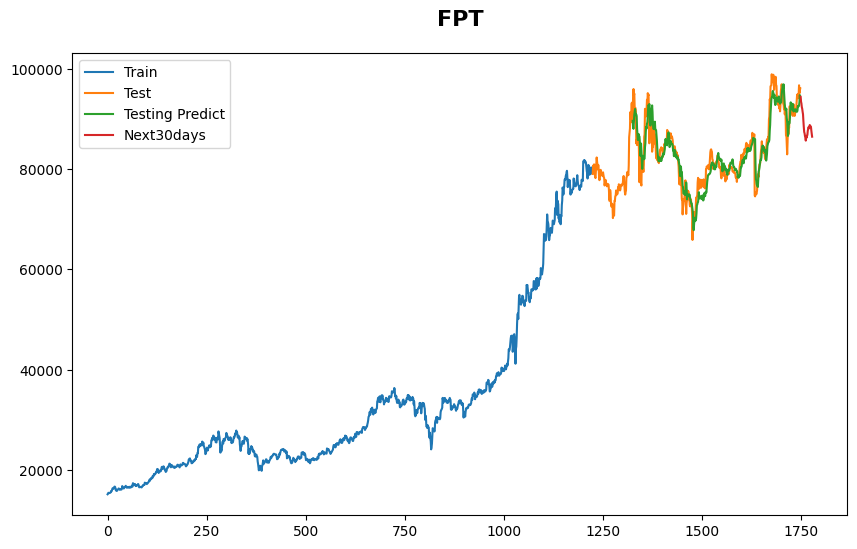

In [ ]:
import numpy as np

forecasted_next_30_days_reshaped = np.array(forecasted_next_30_days).reshape(-1, 1)


plt.figure(figsize=(10, 6))

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(train_data_index, scaler.inverse_transform(np.array(train_data).reshape(-1, 1)))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size + test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(np.array(test_data).reshape(-1, 1)))

test_data_index = pd.RangeIndex(start=train_size + 101, stop=train_size + test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(y_pred_bnn_test.detach().numpy()))
# Lấy index từ ngày tiếp theo trở đi
index_forecasted = range(len(df1), len(df1)+ len(forecasted_next_30_days))
plt.plot(index_forecasted, scaler.inverse_transform(forecasted_next_30_days_reshaped))
plt.title('FPT', fontweight='bold', fontsize=16, pad=20)
plt.legend(['Train', 'Test', 'Testing Predict', 'Next30days'])
plt.show()


## Split data 8:2


In [ ]:
train_size, test_size, train_data, test_data = split_data(0.8, 0.2)

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.distributions import Normal

# Set random seed for reproducibility
torch.manual_seed(42)

# Define the hyperparameters
input_dim = X_train.shape[1]  # Dimension of input features
output_dim = 1  # Dimension of output (predicted value)
hidden_units = 64  # Number of hidden units
learning_rate = 0.001
num_epochs = 500
prior_sigma = 0.1  # Standard deviation of the prior

# Apply Min-Max scaling to the time series data

# Convert the scaled data to tensors
targets = torch.tensor(y_train).view(-1, 1).to(torch.float32)
time_series = torch.tensor(X_train).to(torch.float32)

# Create a DataLoader for batching and shuffling the data
dataset = TensorDataset(time_series, targets)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Define the BNN model
class BNNModel(nn.Module):
    def __init__(self, input_dim, hidden_units, output_dim, prior_sigma):
        super(BNNModel, self).__init__()
        self.layer1 = nn.Linear(input_dim, hidden_units)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(hidden_units, output_dim)
        self.prior_sigma = prior_sigma

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        return x

    def kl_divergence(self):
        kl = 0
        for layer in [self.layer1, self.layer2]:
            weights = layer.weight
            kl += 0.5 * (torch.log(self.prior_sigma**2 / weights.var()) + (weights.var() + (weights.mean() - 0)**2) / self.prior_sigma**2 - 1)
        return kl

# Initialize the BNN model
model = BNNModel(input_dim, hidden_units, output_dim, prior_sigma)

# Define the loss function with KL divergence and negative log likelihood
def bnn_loss(outputs, targets):
    kl_divergence = model.kl_divergence()
    log_likelihood = -Normal(outputs, 1).log_prob(targets).mean()  # Assuming outputs is a Normal distribution
    return kl_divergence + log_likelihood

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
lowest_loss = float('inf')  # Initialize with positive infinity

# Training loop
for epoch in range(num_epochs):
    for batch_inputs, batch_targets in dataloader:
        # Forward pass
        predictions = model(batch_inputs)

        # Compute the combined loss (KL + negative log likelihood)
        loss = bnn_loss(predictions, batch_targets)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update lowest_loss if current loss is lower
        if loss < lowest_loss:
            lowest_loss = loss
            torch.save(model.state_dict(), '/content/best-model-parameters.pt')

    # Print the combined loss (KL + negative log likelihood) after each epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")


Epoch 1/500, Loss: 0.9542140364646912
Epoch 2/500, Loss: 0.9201415181159973
Epoch 3/500, Loss: 0.9194185137748718
Epoch 4/500, Loss: 0.9191899299621582
Epoch 5/500, Loss: 0.9191923141479492
Epoch 6/500, Loss: 0.9195391535758972
Epoch 7/500, Loss: 0.919433057308197
Epoch 8/500, Loss: 0.9197391271591187
Epoch 9/500, Loss: 0.9190818667411804
Epoch 10/500, Loss: 0.9196062088012695
Epoch 11/500, Loss: 0.9193366765975952
Epoch 12/500, Loss: 0.9190735220909119
Epoch 13/500, Loss: 0.919060468673706
Epoch 14/500, Loss: 0.9192360043525696
Epoch 15/500, Loss: 0.9190287590026855
Epoch 16/500, Loss: 0.9191461205482483
Epoch 17/500, Loss: 0.9191727638244629
Epoch 18/500, Loss: 0.9191840887069702
Epoch 19/500, Loss: 0.9192730188369751
Epoch 20/500, Loss: 0.919043779373169
Epoch 21/500, Loss: 0.9191237092018127
Epoch 22/500, Loss: 0.9190801382064819
Epoch 23/500, Loss: 0.9190752506256104
Epoch 24/500, Loss: 0.9191200137138367
Epoch 25/500, Loss: 0.9192829132080078
Epoch 26/500, Loss: 0.919008612632751

In [ ]:
print(model)

BNNModel(
  (layer1): Linear(in_features=100, out_features=64, bias=True)
  (relu): ReLU()
  (layer2): Linear(in_features=64, out_features=1, bias=True)
)


In [ ]:
# Initialize the BNN model
best_model = BNNModel(input_dim, hidden_units, output_dim, prior_sigma)

# Load the state dictionary
state_dict = torch.load('/content/best-model-parameters.pt')

# Load the state dictionary into the model
best_model.load_state_dict(state_dict)

# Test the model
test = torch.tensor(X_test).to(torch.float32)
y_pred_bnn_test = best_model(test)


In [ ]:
# Forecast the next 30 days
forecasted_next_30_days = []

# Assuming df1 is your dataframe
last_10_days = df1.iloc[-time_step:].values.astype(np.float32)  # Apply normalization if needed

for i in range(30):
    X_forecast_tensor = torch.tensor(last_10_days[-time_step:]).unsqueeze(0).to(torch.float32)
    y_pred = best_model(X_forecast_tensor)
    forecasted_next_30_days.append(y_pred.item())

    # Update last_10_days with the latest prediction
    last_10_days = np.append(last_10_days, y_pred.detach().numpy())
    last_10_days = last_10_days[-time_step:]

# Print or use forecasted_next_30_days as needed
print(forecasted_next_30_days)


[0.9593003988265991, 0.9525214433670044, 0.9509189128875732, 0.9478746056556702, 0.9503902196884155, 0.9491744041442871, 0.9521413445472717, 0.9500871896743774, 0.9464307427406311, 0.9491806030273438, 0.9535358548164368, 0.9682954549789429, 0.9703966975212097, 0.974819004535675, 0.9854552745819092, 0.98828125, 0.9904186725616455, 0.992315411567688, 0.9955034255981445, 1.0054911375045776, 1.0087593793869019, 1.009631633758545, 1.012300968170166, 1.0132875442504883, 1.0137319564819336, 1.0169249773025513, 1.0254852771759033, 1.0296930074691772, 1.0313392877578735, 1.037986397743225]


In [ ]:
scaler.inverse_transform(forecasted_next_30_days_reshaped)

array([[94497.1455249 ],
       [93539.54881436],
       [93166.416441  ],
       [92439.94030555],
       [92107.71073158],
       [91507.25443529],
       [91011.0034853 ],
       [89642.32788849],
       [88441.2452219 ],
       [87473.64415784],
       [87187.40459701],
       [86631.4026456 ],
       [86325.42949744],
       [85746.21244369],
       [86653.62731695],
       [86315.795305  ],
       [86773.08930237],
       [86840.86379532],
       [87693.72492882],
       [88063.60588728],
       [88450.96445135],
       [88190.81124233],
       [88470.27285365],
       [88866.70036418],
       [88611.16416432],
       [88617.56194839],
       [88538.10237054],
       [87770.67841612],
       [87117.15402657],
       [86529.33823096]])

In [ ]:
evaluation(scaler.inverse_transform(y_pred_bnn_test.detach().numpy()), scaler.inverse_transform(y_test.reshape(-1,1)))

RMSE = 1667.0223408920317
MAPE = 1.273412392664767
MAE = 1094.7311433232928


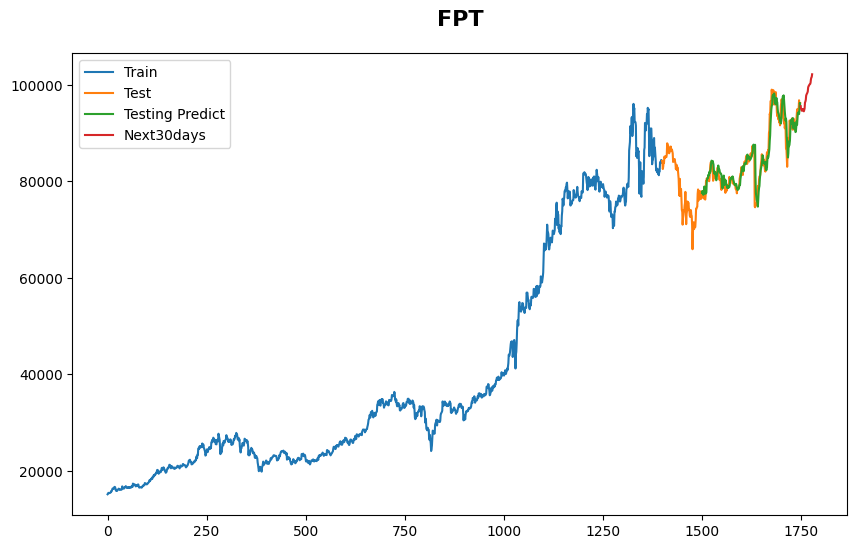

In [ ]:
import numpy as np

forecasted_next_30_days_reshaped = np.array(forecasted_next_30_days).reshape(-1, 1)


plt.figure(figsize=(10, 6))

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(train_data_index, scaler.inverse_transform(np.array(train_data).reshape(-1, 1)))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size + test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(np.array(test_data).reshape(-1, 1)))

test_data_index = pd.RangeIndex(start=train_size + 101, stop=train_size + test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(y_pred_bnn_test.detach().numpy()))
# Lấy index từ ngày tiếp theo trở đi
index_forecasted = range(len(df1), len(df1)+ len(forecasted_next_30_days))
plt.plot(index_forecasted, scaler.inverse_transform(forecasted_next_30_days_reshaped))
plt.title('FPT', fontweight='bold', fontsize=16, pad=20)
plt.legend(['Train', 'Test', 'Testing Predict', 'Next30days'])
plt.show()


## Split data 9:1


In [ ]:
train_size, test_size, train_data, test_data = split_data(0.9, 0.1)

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.distributions import Normal

# Set random seed for reproducibility
torch.manual_seed(42)

# Define the hyperparameters
input_dim = X_train.shape[1]  # Dimension of input features
output_dim = 1  # Dimension of output (predicted value)
hidden_units = 64  # Number of hidden units
learning_rate = 0.001
num_epochs = 500
prior_sigma = 0.1  # Standard deviation of the prior

# Apply Min-Max scaling to the time series data

# Convert the scaled data to tensors
targets = torch.tensor(y_train).view(-1, 1).to(torch.float32)
time_series = torch.tensor(X_train).to(torch.float32)

# Create a DataLoader for batching and shuffling the data
dataset = TensorDataset(time_series, targets)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Define the BNN model
class BNNModel(nn.Module):
    def __init__(self, input_dim, hidden_units, output_dim, prior_sigma):
        super(BNNModel, self).__init__()
        self.layer1 = nn.Linear(input_dim, hidden_units)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(hidden_units, output_dim)
        self.prior_sigma = prior_sigma

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        return x

    def kl_divergence(self):
        kl = 0
        for layer in [self.layer1, self.layer2]:
            weights = layer.weight
            kl += 0.5 * (torch.log(self.prior_sigma**2 / weights.var()) + (weights.var() + (weights.mean() - 0)**2) / self.prior_sigma**2 - 1)
        return kl

# Initialize the BNN model
model = BNNModel(input_dim, hidden_units, output_dim, prior_sigma)

# Define the loss function with KL divergence and negative log likelihood
def bnn_loss(outputs, targets):
    kl_divergence = model.kl_divergence()
    log_likelihood = -Normal(outputs, 1).log_prob(targets).mean()  # Assuming outputs is a Normal distribution
    return kl_divergence + log_likelihood

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
lowest_loss = float('inf')  # Initialize with positive infinity

# Training loop
for epoch in range(num_epochs):
    for batch_inputs, batch_targets in dataloader:
        # Forward pass
        predictions = model(batch_inputs)

        # Compute the combined loss (KL + negative log likelihood)
        loss = bnn_loss(predictions, batch_targets)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update lowest_loss if current loss is lower
        if loss < lowest_loss:
            lowest_loss = loss
            torch.save(model.state_dict(), '/content/best-model-parameters.pt')

    # Print the combined loss (KL + negative log likelihood) after each epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")


Epoch 1/500, Loss: 0.9435027241706848
Epoch 2/500, Loss: 0.9193085432052612
Epoch 3/500, Loss: 0.921079695224762
Epoch 4/500, Loss: 0.9189856648445129
Epoch 5/500, Loss: 0.9191582202911377
Epoch 6/500, Loss: 0.9190253615379333
Epoch 7/500, Loss: 0.9248306155204773
Epoch 8/500, Loss: 0.9189812541007996
Epoch 9/500, Loss: 0.9189493060112
Epoch 10/500, Loss: 0.9194949865341187
Epoch 11/500, Loss: 0.9189669489860535
Epoch 12/500, Loss: 0.919366180896759
Epoch 13/500, Loss: 0.918986439704895
Epoch 14/500, Loss: 0.9189467430114746
Epoch 15/500, Loss: 0.9199433326721191
Epoch 16/500, Loss: 0.9189699292182922
Epoch 17/500, Loss: 0.9190293550491333
Epoch 18/500, Loss: 0.9189721345901489
Epoch 19/500, Loss: 0.9191226959228516
Epoch 20/500, Loss: 0.9190226793289185
Epoch 21/500, Loss: 0.9189845323562622
Epoch 22/500, Loss: 0.918965756893158
Epoch 23/500, Loss: 0.9193159341812134
Epoch 24/500, Loss: 0.9190932512283325
Epoch 25/500, Loss: 0.9189630746841431
Epoch 26/500, Loss: 0.9190014004707336
Ep

In [ ]:
print(model)

BNNModel(
  (layer1): Linear(in_features=100, out_features=64, bias=True)
  (relu): ReLU()
  (layer2): Linear(in_features=64, out_features=1, bias=True)
)


In [ ]:
# Initialize the BNN model
best_model = BNNModel(input_dim, hidden_units, output_dim, prior_sigma)

# Load the state dictionary
state_dict = torch.load('/content/best-model-parameters.pt')

# Load the state dictionary into the model
best_model.load_state_dict(state_dict)

# Test the model
test = torch.tensor(X_test).to(torch.float32)
y_pred_bnn_test = best_model(test)


In [ ]:
# Forecast the next 30 days
forecasted_next_30_days = []

# Assuming df1 is your dataframe
last_10_days = df1.iloc[-time_step:].values.astype(np.float32)  # Apply normalization if needed

for i in range(30):
    X_forecast_tensor = torch.tensor(last_10_days[-time_step:]).unsqueeze(0).to(torch.float32)
    y_pred = best_model(X_forecast_tensor)
    forecasted_next_30_days.append(y_pred.item())

    # Update last_10_days with the latest prediction
    last_10_days = np.append(last_10_days, y_pred.detach().numpy())
    last_10_days = last_10_days[-time_step:]

# Print or use forecasted_next_30_days as needed
print(forecasted_next_30_days)


[0.9587900042533875, 0.9495996236801147, 0.9488851428031921, 0.9420338273048401, 0.9385972023010254, 0.9370411038398743, 0.9297525882720947, 0.9207735657691956, 0.9078027606010437, 0.9095473289489746, 0.9006572961807251, 0.8996978402137756, 0.8918545246124268, 0.8858559727668762, 0.8873698115348816, 0.8786088824272156, 0.8761736154556274, 0.8766205906867981, 0.8763849139213562, 0.8779817819595337, 0.8767855167388916, 0.8732818961143494, 0.8761751055717468, 0.8783345818519592, 0.8771340847015381, 0.8783803582191467, 0.884285032749176, 0.8871961236000061, 0.8825264573097229, 0.8863704800605774]


In [ ]:
forecasted_next_30_days

[0.9587900042533875,
 0.9495996236801147,
 0.9488851428031921,
 0.9420338273048401,
 0.9385972023010254,
 0.9370411038398743,
 0.9297525882720947,
 0.9207735657691956,
 0.9078027606010437,
 0.9095473289489746,
 0.9006572961807251,
 0.8996978402137756,
 0.8918545246124268,
 0.8858559727668762,
 0.8873698115348816,
 0.8786088824272156,
 0.8761736154556274,
 0.8766205906867981,
 0.8763849139213562,
 0.8779817819595337,
 0.8767855167388916,
 0.8732818961143494,
 0.8761751055717468,
 0.8783345818519592,
 0.8771340847015381,
 0.8783803582191467,
 0.884285032749176,
 0.8871961236000061,
 0.8825264573097229,
 0.8863704800605774]

In [ ]:
evaluation(scaler.inverse_transform(y_pred_bnn_test.detach().numpy()), scaler.inverse_transform(y_test.reshape(-1,1)))

RMSE = 1932.6449385309468
MAPE = 1.6736279690057965
MAE = 1538.0499366554056


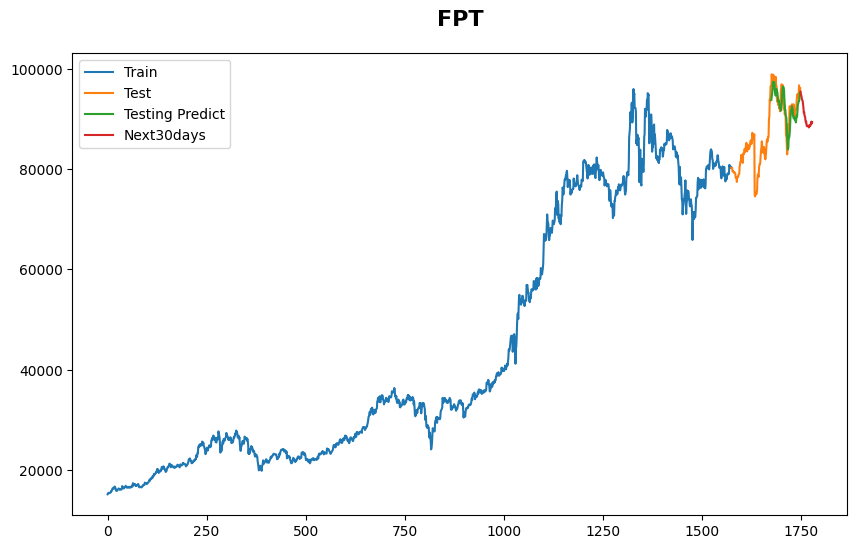

In [ ]:
import numpy as np

forecasted_next_30_days_reshaped = np.array(forecasted_next_30_days).reshape(-1, 1)


plt.figure(figsize=(10, 6))

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(train_data_index, scaler.inverse_transform(np.array(train_data).reshape(-1, 1)))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size + test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(np.array(test_data).reshape(-1, 1)))

test_data_index = pd.RangeIndex(start=train_size + 101, stop=train_size + test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(y_pred_bnn_test.detach().numpy()))
# Lấy index từ ngày tiếp theo trở đi
index_forecasted = range(len(df1), len(df1)+ len(forecasted_next_30_days))
plt.plot(index_forecasted, scaler.inverse_transform(forecasted_next_30_days_reshaped))
plt.title('FPT', fontweight='bold', fontsize=16, pad=20)
plt.legend(['Train', 'Test', 'Testing Predict', 'Next30days'])
plt.show()
